In [3]:
import numpy as np
import pandas as pd
from sqlalchemy import or_

from app.models import Session, Headline, Article, Agency
from app.utils import Country, Config

In [4]:
s = Session()
data = s.query(
    Headline.id, Article.id, Agency.name, Headline.processed, Headline.first_accessed, Headline.last_accessed
).join(Headline.article).join(Article.agency).filter(
    or_(Agency._country == Country.us.value, Agency.name.in_(Config.exempted_foreign_media))
).all()
s.close()

In [5]:
raw_df = pd.DataFrame(data, columns=['hid', 'aid', 'agency', 'title', 'first', 'last'])
print(raw_df.shape)

(1038208, 6)


In [6]:
from tqdm import tqdm

tqdm.pandas()
# Take only the first 1000 rows for now
# df = raw_df.head(10000).copy()
df = raw_df.copy()
# Convert the datetimes from utc to NY time. They're not timezone aware
df['first'] = df['first'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
df['last'] = df['last'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
# Get the timedelta between the first and last access
df['delta'] = df['last'] - df['first']
# Drop the rows where the delta is more than 3 days. This should filter out normal links not to real stories
df = df[df['delta'] <= pd.Timedelta(days=3)]

In [7]:
# filtering by us and exempted media really improves this!
def get_hours(row):
    first = row['first']
    last = row['last']
    # Zero out the minutes and seconds
    first_ts = first.replace(minute=0, second=0, microsecond=0).timestamp()
    last_ts = last.replace(minute=0, second=0, microsecond=0).timestamp()
    # get every half hour between the first and last access
    hours = np.arange(first_ts, last_ts, 1800, dtype=int)
    # Filter out the hours that are not in the same day as the first access
    return hours[(hours <= last_ts) & (hours >= first_ts)]
    
df['halfhour'] = df.progress_apply(get_hours, axis=1)

100%|██████████| 981330/981330 [00:29<00:00, 32934.43it/s]


In [8]:
# Next we explode the hours column so that each row corresponds to a single hour
df = df.explode('halfhour')
# Reset the index
df.reset_index(drop=True, inplace=True)
# Convert the hours column to a datetime
df['halfhour'] = pd.to_datetime(df['halfhour'], unit='s')
df = df[['title', 'halfhour']]

In [9]:
df.sample(5)

,title,halfhour
17420753,Fintech bottom?,2024-06-13 13:30:00
15431245,Eric Shows Everything That's Wrong With Mid TV,2024-06-01 09:00:00
16566894,Kia installing free anti-theft software during...,2024-06-09 13:30:00
4441092,Journalist schools Peter Navarro after he dare...,2024-03-19 20:00:00
1453974,Should We Be Arming Teachers and School Staff?,2024-02-28 12:00:00


In [10]:
# Group by the hours column and apply the get_newsiness function to the titles
# Eventually we can speed this up with multiprocessing I think.
# For now though, this is fine. More than a million headlines Seems to be taking under 20 minutes.
# Recalculation will be expensive! But we won't do it often.
# We'll save the results as a csv for incorporation in the website.
# Simple solutions are best.

import multiprocessing as mp
from app.analysis.newsiness import get_newsiness

titles_by_hour = [group["title"].tolist() for _, group in df.groupby('halfhour')]
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.imap(get_newsiness, titles_by_hour)
    newsiness = list(tqdm(results, total=len(titles_by_hour)))


# It took almost 22 minutes for the first run.
# newsiness = df.groupby('hours')['title'].progress_apply(get_newsiness)


100%|██████████| 7088/7088 [01:16<00:00, 93.07it/s] 


In [11]:
# Create a dataframe from the groupby object and add a column of the newsiness
newsiness_df = df.groupby('halfhour').first().reset_index()
newsiness_df = newsiness_df[['halfhour']]
newsiness_df['newsiness'] = newsiness
newsiness_df.head()

,halfhour,newsiness
0,2024-02-16 20:00:00,2.750258
1,2024-02-16 20:30:00,2.750258
2,2024-02-16 21:00:00,2.498704
3,2024-02-16 21:30:00,2.498704
4,2024-02-16 22:00:00,2.612245


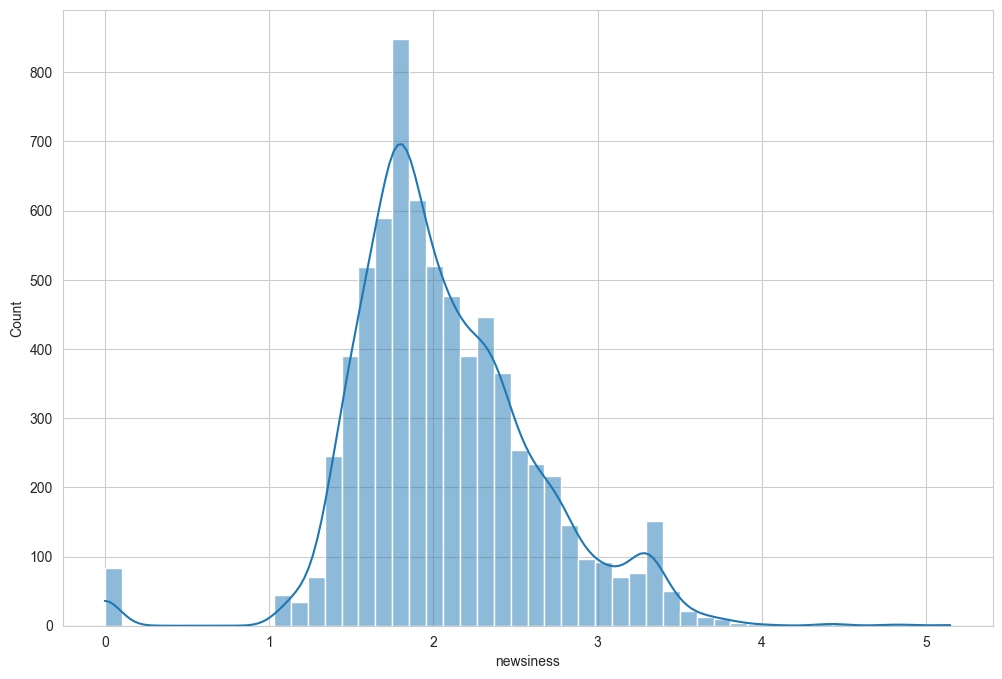

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot a histogram of the newsiness
plt.figure(figsize=(12, 8))
sns.histplot(newsiness_df['newsiness'], bins=50, kde=True)
plt.show()


In [13]:
# Get some statistics
newsiness_df['newsiness'].describe()

count    7088.000000
mean        2.069279
std         0.565596
min         0.000000
25%         1.712586
50%         1.976902
75%         2.380802
max         5.146977
Name: newsiness, dtype: float64

In [14]:
# Let's sample some headlines from the highest newsiness hour
df[df['halfhour'] == newsiness_df[newsiness_df['newsiness'] == newsiness_df['newsiness'].max()]['halfhour'].values[0]].sample(10)

,title,halfhour
13656427,Michael Cohen resumes testimony in Trump's hus...,2024-05-20 15:00:00
13624705,Why crypto VCs are fretting about distribution...,2024-05-20 15:00:00
13373855,Ben Whishaw on Giving the Riskiest Performance...,2024-05-20 15:00:00
13648868,"Michael Cohen Cops to Stealing $30,000 From Trump",2024-05-20 15:00:00
13644724,Report: Pricey Electric Cars Driven 20 Percent...,2024-05-20 15:00:00
13613075,"GOP Sycophants Flock to Trump's Trial, Betrayi...",2024-05-20 15:00:00
13622098,Putin says Iran's Raisi was 'true friend of Ru...,2024-05-20 15:00:00
13531795,Louisville Officials: No Bodycam Footage Avail...,2024-05-20 15:00:00
13430907,"Zoe Saldaña Stars in Emilia Pérez, a Movie Unl...",2024-05-20 15:00:00
13657442,The Latest | ICC prosecutor's request for arre...,2024-05-20 15:00:00


In [15]:
# Now create a column of the day of the week
newsiness_df['day'] = newsiness_df['halfhour'].dt.day_name()
# Convert the "hours" column, which is actually halfhour to the hour of the day to an integer representing the 24 hour clock (00, 30, 60, 90, etc)
newsiness_df['halfhour'] = newsiness_df['halfhour'].dt.hour * 60 + newsiness_df['halfhour'].dt.minute

# Create a df of group by hour and day and take the mean of the newsiness and the median of the newsiness
newsiness_df = newsiness_df.groupby(['halfhour', 'day'])['newsiness'].agg(['mean', 'median', 'std']).reset_index()
newsiness_df.head()

,halfhour,day,mean,median,std
0,0,Friday,1.861861,1.876211,0.658796
1,0,Monday,2.247289,2.278593,0.484365
2,0,Saturday,2.269164,2.182655,0.434490
3,0,Sunday,2.082668,1.884660,0.527994
4,0,Thursday,1.990977,2.008419,0.610202


In [16]:
newsiness_df.to_csv('../newsiness.csv', index=False)

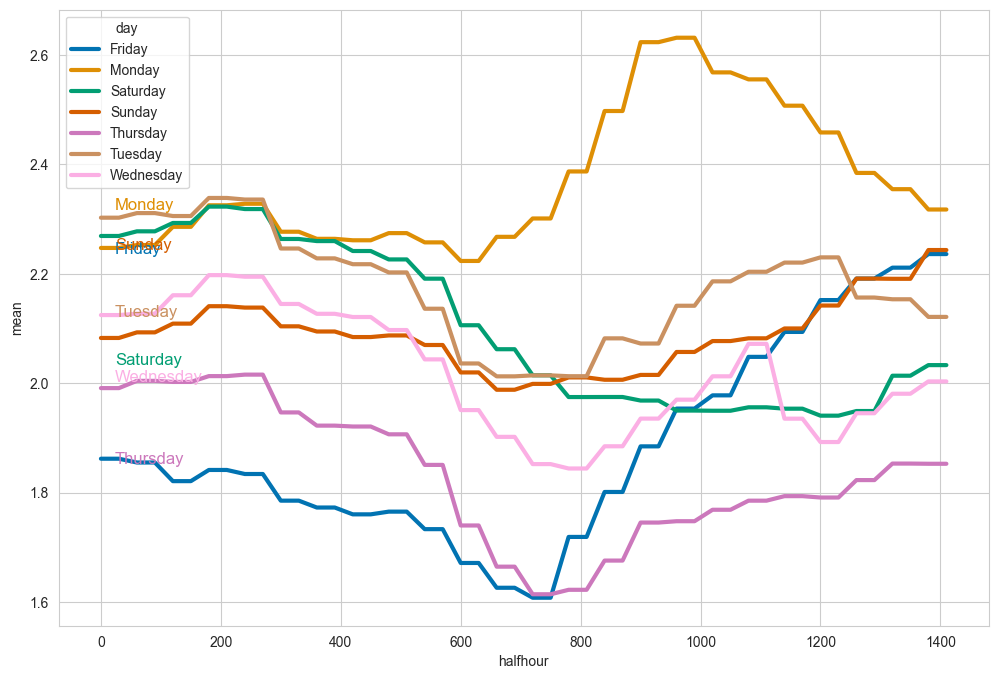

In [17]:
# Plot the mean newsiness by hour
import seaborn as sns
import matplotlib.pyplot as plt

# Colorblind friendly
sns.set_palette('colorblind')
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='mean', hue='day', lw=3)
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['mean'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()

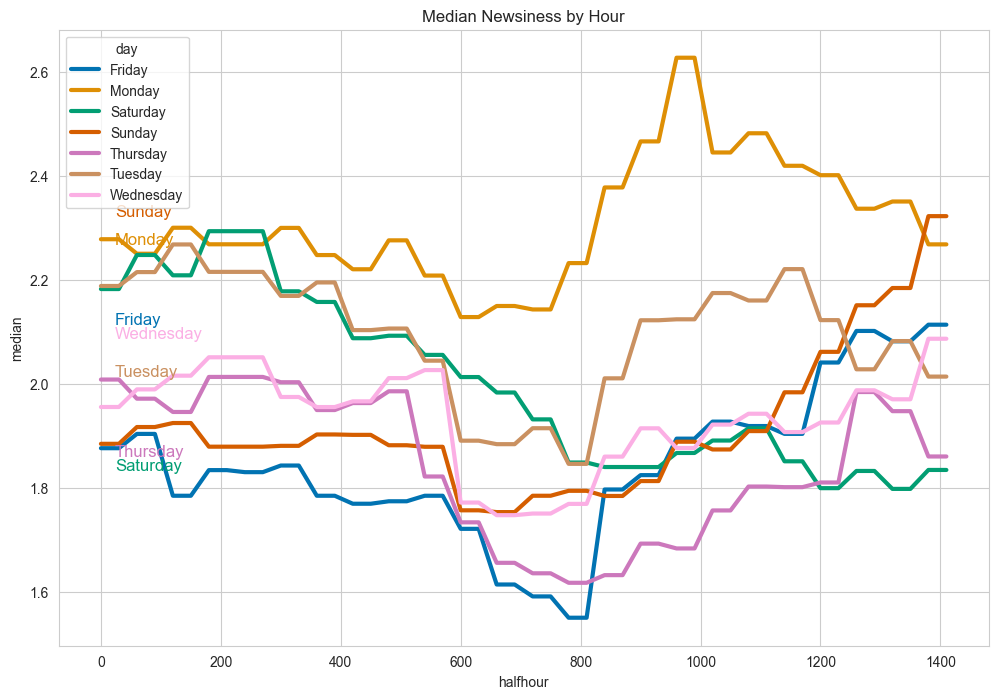

In [18]:
# Plot the median newsiness by hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='median', hue='day', lw=3)
# Add a title
plt.title('Median Newsiness by Hour')
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['median'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()


In [19]:
# Rank the days by newsiness
newsiness_df.groupby('day')['mean'].mean().sort_values(ascending=False)

day
Monday       2.368820
Tuesday      2.177808
Saturday     2.104524
Sunday       2.088542
Wednesday    2.021539
Friday       1.883404
Thursday     1.835326
Name: mean, dtype: float64

In [20]:
# Rank the hours by newsiness
newsiness_df.groupby('halfhour')['mean'].mean().sort_values(ascending=False)

halfhour
180     2.168471
210     2.168471
240     2.166375
270     2.166375
120     2.139610
150     2.139610
60      2.131473
90      2.131473
0       2.125586
30      2.125586
1380    2.115301
1410    2.115301
330     2.109615
300     2.109615
1320    2.108210
1350    2.108210
1110    2.100320
1080    2.100320
390     2.095471
360     2.095471
1290    2.091491
1260    2.091491
450     2.086670
420     2.086670
1230    2.086607
1200    2.086607
1170    2.086212
1140    2.086212
510     2.079881
480     2.079881
1020    2.077121
1050    2.077121
960     2.064450
990     2.064450
570     2.040226
540     2.040226
900     2.034881
930     2.034881
870     1.988834
840     1.988834
630     1.963837
600     1.963837
810     1.938577
780     1.938577
690     1.931762
660     1.931762
750     1.914610
720     1.914610
Name: mean, dtype: float64

In [21]:
# Find the newsiest hourday
newsiness_df[newsiness_df['mean'] == newsiness_df['mean'].max()]

,halfhour,day,mean,median,std
225,960,Monday,2.631677,2.628069,0.791573
232,990,Monday,2.631677,2.628069,0.791573


In [22]:
# Group by morning, afternoon, evening, night and find the busiest period on which day
newsiness_df['period'] = pd.cut(newsiness_df['halfhour'], bins=[v * 60 for v in [0, 6, 12, 18, 24]],
                                labels=['night', 'morning', 'afternoon', 'evening'])
newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


C:\Users\malan\AppData\Local\Temp\ipykernel_27012\93058822.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


day        period   
Monday     afternoon    2.522772
           evening      2.418240
Tuesday    night        2.300455
Saturday   night        2.290002
Monday     night        2.287390
           morning      2.261123
Tuesday    evening      2.178830
Sunday     evening      2.165188
Friday     evening      2.165138
Saturday   morning      2.160693
Wednesday  night        2.158422
Tuesday    morning      2.120984
Sunday     night        2.112207
Tuesday    afternoon    2.100651
Sunday     morning      2.049268
           afternoon    2.034383
Wednesday  morning      2.017284
Thursday   night        1.989707
Saturday   evening      1.975926
           afternoon    1.967036
Wednesday  evening      1.962239
           afternoon    1.934686
Friday     afternoon    1.860588
           night        1.825568
Thursday   evening      1.819141
           morning      1.808370
           afternoon    1.709765
Friday     morning      1.707597
Name: mean, dtype: float64